# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [468]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#! pip install chart_studio
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Output hidden; open in https://colab.research.google.com to view.

In [469]:
#from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [470]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('/content/drive/MyDrive/6_Donors_choose_NB/preprocessed_data.csv')

In [471]:
def remove_num(essay):
  out = ''
  for i in essay:
    if i.isnumeric():
      pass
    else:
      out+=i
  out = re.sub(' +', ' ', out)
  return out.strip()
data.essay = data.essay.apply(remove_num)

In [472]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [473]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [474]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)





<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [475]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_essay_bow = CountVectorizer(min_df=10,ngram_range=(1,2),max_features = 7000)
vectorizer_essay_bow.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay_bow.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer_essay_bow.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


(87398, 8) (87398,)
(21850, 8) (21850,)
After vectorizations
(87398, 7000) (87398,)
(21850, 7000) (21850,)


In [476]:
X_train_essay_bow_columms = vectorizer_essay_bow.get_feature_names()

In [477]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)

vectorizer_essay_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,2),max_features = 7000)
vectorizer_essay_tfidf.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_essay_tfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)



After vectorizations
(87398, 7000) (87398,)
(21850, 7000) (21850,)


In [478]:
X_train_essay_tfidf_columms = vectorizer_essay_tfidf.get_feature_names()

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [479]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().


<h3>1.4.1 encoding categorical features: School State</h3>

In [480]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(87398, 51) (87398,)
(21850, 51) (21850,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [481]:
categorical_features = vectorizer.get_feature_names()


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [482]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(87398, 5) (87398,)
(21850, 5) (21850,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [483]:
categorical_features += vectorizer.get_feature_names()

<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [484]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(87398, 4) (87398,)
(21850, 4) (21850,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [485]:
categorical_features += vectorizer.get_feature_names()

<h3>1.4.4 encoding categorical features: clean_categories</h3>

In [486]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(87398, 9) (87398,)
(21850, 9) (21850,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [487]:
categorical_features += vectorizer.get_feature_names()

<h3>1.4.5 encoding categorical features: clean_subcategories</h3>

In [488]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(87398, 30) (87398,)
(21850, 30) (21850,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [489]:
categorical_features += vectorizer.get_feature_names()

<h3>1.4.6 encoding numerical features: Price</h3>

In [490]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(87398, 1) (87398,)
(21850, 1) (21850,)


In [491]:
numerical_features = ['price','teacher_number_of_previously_posted_projects']

<h3>1.4.7 encoding numerical features: teacher_number_of_previously_posted_projects</h3>

In [492]:
normalizer = Normalizer()
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(87398, 1) (87398,)
(21850, 1) (21850,)



### 1.4.8 Concatinating all the features to set 1

In [493]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_set1 = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te_set1 = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()

print("Final Data matrix")
print(X_tr_set1.shape, y_train.shape)
print(X_te_set1.shape, y_test.shape)
print("="*100)

Final Data matrix
(87398, 7101) (87398,)
(21850, 7101) (21850,)


In [494]:
set1features = X_train_essay_bow_columms+categorical_features+numerical_features


### 1.4.9 Concatinating all the features to set 2

In [495]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_set2 = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te_set2 = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()

print("Final Data matrix")
print(X_tr_set2.shape, y_train.shape)
print(X_te_set2.shape, y_test.shape)
print("="*100)

Final Data matrix
(87398, 7101) (87398,)
(21850, 7101) (21850,)


In [496]:
set2features = X_train_essay_tfidf_columms+categorical_features+numerical_features

<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

8        0.0
9    0.00001
5     0.0005
1      0.001
7      0.005
6        0.1
2          5
4         10
3         50
0        100
Name: param_alpha, dtype: object


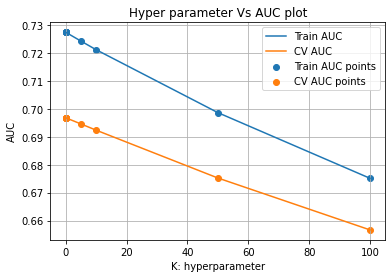

,param_alpha,mean_train_score,mean_test_score
8,0.0,0.727412,0.696798
9,0.00001,0.727412,0.696798
5,0.0005,0.727412,0.696798
1,0.001,0.727411,0.696797
7,0.005,0.727409,0.696795


In [497]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

NB = MultinomialNB()
parameters = {'alpha':[0.0,0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = RandomizedSearchCV(NB, parameters, cv=5, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_set1, y_train)
#print(results)
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']
print(K)
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results[['param_alpha','mean_train_score','mean_test_score']].head()


In [498]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in tqdm(range(0, tr_loop, 1000)):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [499]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.
best_alpha = 0.001
NB = MultinomialNB(alpha = 1.0)
NB.fit(X_tr_set1, y_train)
#print(results)
y_train_pred_set1 = batch_predict(NB, X_tr_set1)    
y_test_pred_set1 = batch_predict(NB, X_te_set1)


100%|██████████| 21/21 [00:00<00:00, 302.75it/s]


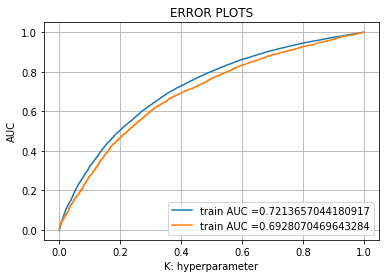

In [500]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_set1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_set1)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [501]:
result_compaare = pd.DataFrame(data = [['BOW','Brute',0,0],['TF-IDF','Brute',0,0]],columns = ['Vectorizer','Model','Hyper Parameter','AUC'])
result_compaare.iloc[0,2] = best_alpha
result_compaare.iloc[0,3] = auc(test_fpr, test_tpr)


In [502]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


In [503]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.44600446904216634 for threshold 0.779
Train confusion matrix
[[ 8814  4420]
 [24499 49665]]


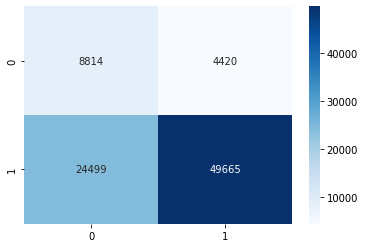

Test confusion matrix
[[ 2105  1203]
 [ 6202 12340]]


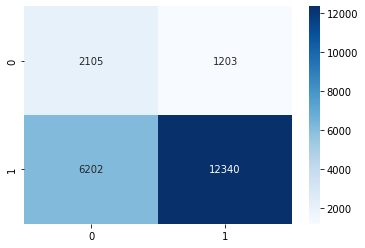

In [504]:
import seaborn as sns
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set1, best_t)))
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set1, best_t)),cmap = 'Blues',annot = True,fmt = 'g')
plt.show()
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set1, best_t)))
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set1, best_t)),cmap = 'Blues',annot = True,fmt = 'g')
plt.show()

#### Set 2

7         0.0
9         0.0
6    0.000001
2      0.0001
8      0.0001
4       0.001
3        0.01
1           1
5          10
0         100
Name: param_alpha, dtype: object


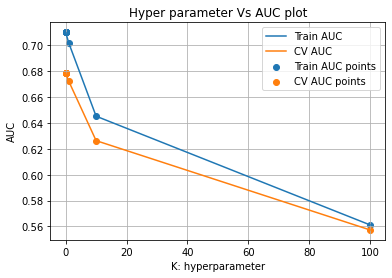

,param_alpha,mean_train_score,mean_test_score
7,0.0,0.710013,0.678446
9,0.0,0.710013,0.678446
6,0.000001,0.710013,0.678446
2,0.0001,0.710012,0.678445
8,0.0001,0.710012,0.678445
4,0.001,0.710005,0.678440
3,0.01,0.709930,0.678386
1,1,0.701840,0.672256
5,10,0.645172,0.626295
0,100,0.561223,0.557351


In [505]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
NB = MultinomialNB()
parameters = {'alpha':[0.0,0.0000001,0.000001,0.0001,0.0001,0.001,0.01,0.1,1,10,100]}
clf = RandomizedSearchCV(NB, parameters, cv=5, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_set2, y_train)
#print(results)
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']
print(K)
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results[['param_alpha','mean_train_score','mean_test_score']]



In [506]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.
best_alpha = 0.0001
NB = MultinomialNB(alpha = best_alpha)
NB.fit(X_tr_set2, y_train)
#print(results)
y_train_pred_set2 = batch_predict(NB, X_tr_set2)    
y_test_pred_set2 = batch_predict(NB, X_te_set2)

100%|██████████| 21/21 [00:00<00:00, 243.96it/s]


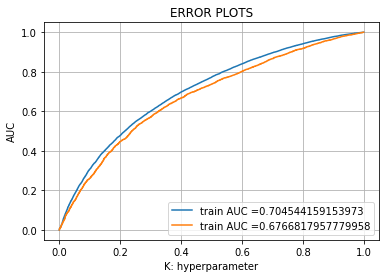

In [507]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_set2)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_set2)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


In [508]:
result_compaare.iloc[1,2] = best_alpha
result_compaare.iloc[1,3] = auc(test_fpr, test_tpr)

In [509]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


the maximum value of tpr*(1-fpr) 0.42373475289075235 for threshold 0.844
Train confusion matrix
[[ 8533  4701]
 [25425 48739]]


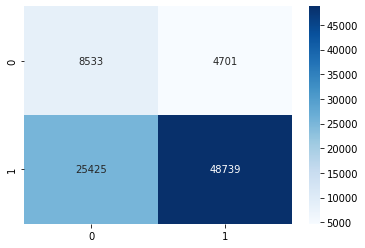

Test confusion matrix
[[ 2034  1274]
 [ 6388 12154]]


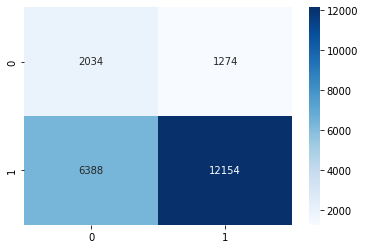

In [510]:
import seaborn as sns
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set2, best_t)))
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set2, best_t)),cmap = 'Blues',annot = True,fmt = 'g')
plt.show()
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set2, best_t)))
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set2, best_t)),cmap = 'Blues',annot = True,fmt = 'g')
plt.show()

In [511]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)
features_negetive_class = pd.DataFrame(list(zip(set2features,NB.feature_log_prob_[0])), columns = ['feature','value'])
features_positive_class = pd.DataFrame(list(zip(set2features,NB.feature_log_prob_[1])), columns = ['feature','value'])
def epower(val):
  return np.e**val
features_negetive_class['prob'] = features_negetive_class['value'].apply(epower)
features_positive_class['prob'] = features_positive_class['value'].apply(epower)
features_negetive_class.sort_values(by= 'prob',ascending=False,inplace = True)
features_positive_class.sort_values(by= 'prob',ascending=False,inplace = True)


# Top features of positive class

In [512]:
from tabulate import tabulate
print(tabulate(features_negetive_class.head(20), headers='keys', tablefmt='psql',showindex=False))


+----------------------------------------------+----------+------------+
| feature                                      |    value |       prob |
|----------------------------------------------+----------+------------|
| price                                        | -2.88005 | 0.0561319  |
| teacher_number_of_previously_posted_projects | -3.27589 | 0.0377832  |
| mrs                                          | -3.57244 | 0.0280871  |
| literacy_language                            | -3.74061 | 0.0237396  |
| grades_prek_2                                | -3.79062 | 0.0225817  |
| math_science                                 | -3.79891 | 0.0223951  |
| ms                                           | -3.88489 | 0.02055    |
| grades_3_5                                   | -3.99589 | 0.0183911  |
| mathematics                                  | -4.22679 | 0.0145992  |
| literacy                                     | -4.23408 | 0.0144932  |
| literature_writing                           | -4

<BarContainer object of 20 artists>

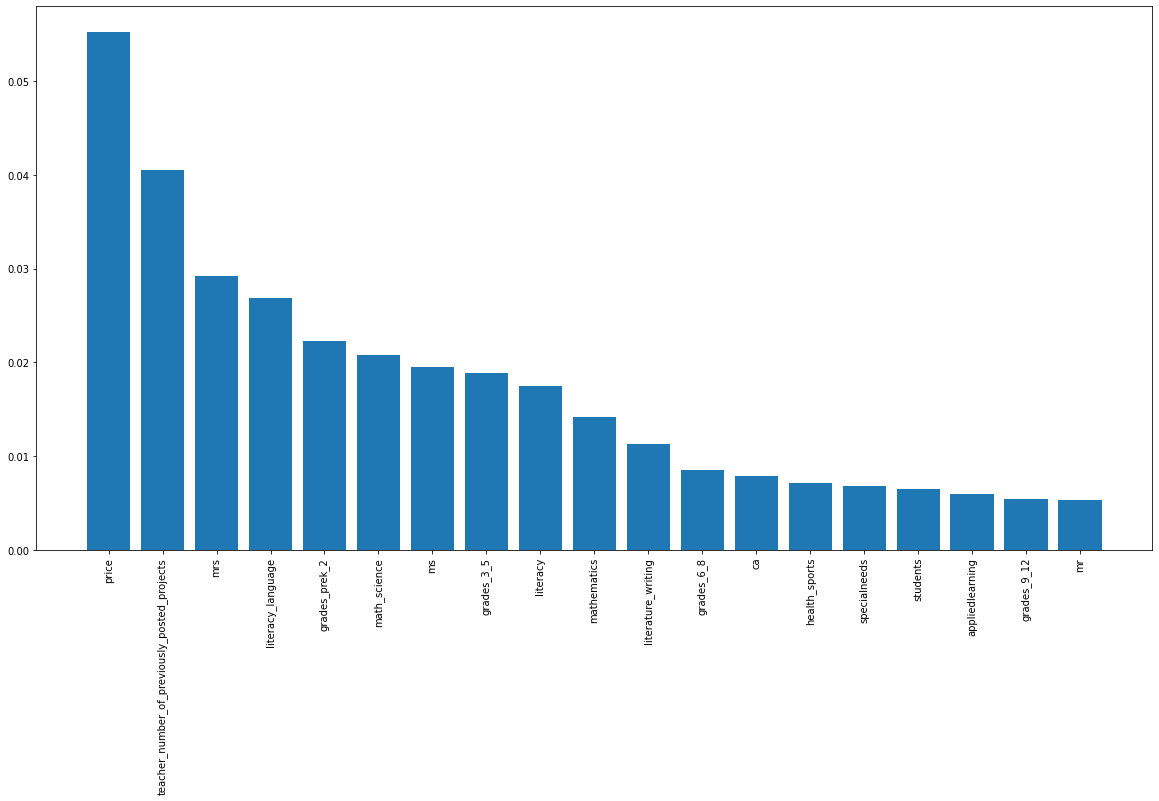

In [513]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation = 90)
plt.bar(features_positive_class.head(20)['feature'], features_positive_class.head(20)['prob'])

# Top features of negetive class

In [514]:
from tabulate import tabulate
print(tabulate(features_positive_class.head(20), headers='keys', tablefmt='psql',showindex=False))

+----------------------------------------------+----------+------------+
| feature                                      |    value |       prob |
|----------------------------------------------+----------+------------|
| price                                        | -2.89695 | 0.0551915  |
| teacher_number_of_previously_posted_projects | -3.20534 | 0.0405453  |
| mrs                                          | -3.53406 | 0.0291861  |
| literacy_language                            | -3.6161  | 0.0268873  |
| grades_prek_2                                | -3.80383 | 0.0222853  |
| math_science                                 | -3.8741  | 0.0207731  |
| ms                                           | -3.93506 | 0.0195445  |
| grades_3_5                                   | -3.96769 | 0.0189171  |
| literacy                                     | -4.04737 | 0.0174682  |
| mathematics                                  | -4.25784 | 0.0141529  |
| literature_writing                           | -4

<BarContainer object of 20 artists>

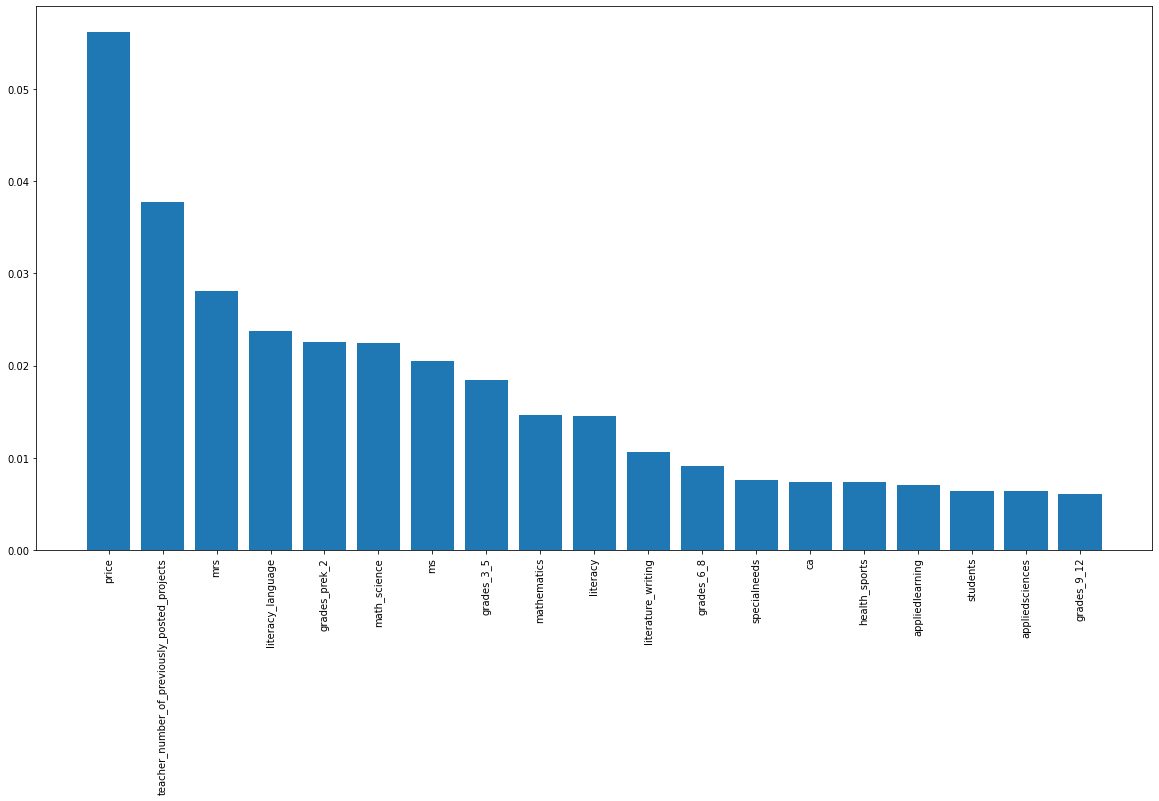

In [515]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation = 90)
plt.bar(features_negetive_class.head(20)['feature'], features_negetive_class.head(20)['prob'])

<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [516]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/


step 1 : We loaded the preprocessed donor choose dataset.

step 2: we vectorised essays using BOW approach and TF-IDF approach

step 3: we one hot encoded categorical features

step 4: normalised the numerical features

step 5: built Multinomial Naive Bayes on both the BOW and TF-IDF features along with categorical and numerical features

step 6: found best hyper parameters for each of the approaches and predicted the roc on both 

step 7: printed the features which are contributing more towards the positive and negetive classes

step 8: summarised the result below we can clearly see that BOW model is performing better than TF-IDF model.

In [517]:
print(tabulate(result_compaare, headers='keys', tablefmt='psql',showindex=False))


+--------------+---------+-------------------+----------+
| Vectorizer   | Model   |   Hyper Parameter |      AUC |
|--------------+---------+-------------------+----------|
| BOW          | Brute   |            0.001  | 0.692807 |
| TF-IDF       | Brute   |            0.0001 | 0.676682 |
+--------------+---------+-------------------+----------+
